## Basic Setup

In [ ]:
# File directory
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('/content/drive/My Drive')
os.chdir('NLP Group/')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  8 19:10:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Import all necessary libraries
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize,PunktSentenceTokenizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,precision_score, recall_score, roc_auc_score, log_loss, roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
!pip install wordcloud
from wordcloud import WordCloud
from gensim.models import Word2Vec
from collections import Counter
import time
from sklearn.decomposition import LatentDirichletAllocation
import torch
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

!pip install contractions
import contractions

!pip install autocorrect
from autocorrect import Speller

Populating the interactive namespace from numpy and matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=b83617903e45655a3dfd54bf8c850c04a831866a7879ca336915b992702280ac
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


# Dataset B

## Data Preprocessing
    The dataset has 348,124 reddit posts, 1 empty text, 14 empty labels and completely balanced.

In [ ]:
# Read in dataset B
data=pd.read_csv('SuicideAndDepression_Detection.csv')
data

,text,class
0,Does life actually work for most / non-depress...,depression
1,I found my friend's bodyIt was almost nine yea...,depression
2,Ex Wife Threatening SuicideRecently I left my ...,SuicideWatch
3,Am I weird I don't get affected by compliments...,teenagers
4,Finally 2020 is almost over... So I can never ...,teenagers
...,...,...
348119,You how you can tell i have so many friends an...,teenagers
348120,pee probably tastes like salty tea😏💦‼️ can som...,teenagers
348121,The usual stuff you find hereI'm not posting t...,SuicideWatch
348122,"I confronted my mother. Extremely isolated, wi...",depression


#### Checking shape, null, class distribution

In [ ]:
# check how many posts in this dataset
data.shape

(348124, 2)

In [ ]:
# check how many labels and what are the unique labels
data['class'].value_counts()

,count
class,
SuicideWatch,116037
teenagers,116037
depression,116036


In [ ]:
# check null values
data.isnull().sum()

,0
text,1
class,14


### Text Cleaning

In [ ]:
# Create a copy of data with stratified sampling for 10% of original dataset, equal pecentage for each class
df = data.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)

# Handling null data
df = df.dropna(subset=['text', 'class'])
df = df[df['text'].str.strip() != '']
df = df[df['class'].str.strip() != '']

# Change the column name from 'class' to label'
df = df.rename(columns={'class': 'label'})

# Replace 'teenagers' with 'non-suicide', 'SuicideWatch' with 'suicide' in column label
df['label'] = df['label'].replace({'teenagers': 'non-suicide', 'SuicideWatch': 'suicide'})

# Remove HTML in the text column
df['cleaned_text'] = df['text'].str.replace(r'<[^<>]*>', '', regex=True)

# Remove new lines in the text column
df['cleaned_text'] = df['cleaned_text'].str.replace('\n', ' ')

# Remove URLs in the text column
df['cleaned_text'] = df['cleaned_text'].str.replace(r'http\S+|www.\S+', '', regex=True)

# Remove special characters (including emojis) with space in the text column
df['cleaned_text'] = df['cleaned_text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

# Convert the 'cleaned_text' column to string type to ensure all values are strings
df['cleaned_text'] = df['cleaned_text'].astype(str)

# Replacing contractions using contraction dictionary
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: contractions.fix(x))

# Remove english stopwords with nltk, except for 'I'
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.discard('i')

# Remove custom stopwords as navigation or command terms, system feedback words, common internet slang
simple_stopwords = set([
    'ok', 'like and share', 'followers', 'repost', 'click', 'press', 'enter', 'submit', 'loading', 'processing', 'completed',
    'lol', 'lmao', 'btw', 'brb', 'fb', 'Welp'])
stop_words.update(simple_stopwords)
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Add a space in a word with capital letter in between, e.g bodyIt
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'([a-z])([A-Z])', r'\1 \2', x))

# Convert words to singular
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Apply negation tagging
#df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\b(?:not|n\'t)\b', 'not_', x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Verify GPU usage
if not spacy.require_gpu():
    print("GPU is not available. The code will run on CPU.")

# Load SpaCy model (ensure it supports GPU if GPU is available)
nlp = spacy.load('en_core_web_sm')

# Function for lemmatization
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Apply lemmatization to the 'cleaned_text' column
df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)

In [ ]:
# Separate due to long runtime
# Lemmatization using SpaCy
# Run this code with GPU
#nlp = spacy.load('en_core_web_sm')
#f['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

In [ ]:
df.head()

,text,label,cleaned_text
0,Former suicidal peep looking for genuine help....,suicide,former suicidal peep look genuine help so I fi...
1,"Pain, feel like i can go on anymoreIm in const...",suicide,pain feel like I go anymore I m constant pain ...
2,My girlfriends suicidal but isn’t here legally...,suicide,girlfriend suicidal legally my russian girlfri...
3,Can't get over a breakup. Haven't talked to he...,suicide,can not get breakup talk 14 week 3 day I m thi...
4,Everyone suddenly cares?! Ha.Tried to commit s...,suicide,everyone suddenly care ha try commit self murd...


### Try some examples after cleaning

In [ ]:
# get the row with text containing specific patterns/words/characters/contractions - emojis
df[df['text'].str.contains("pee probably tastes like salty tea", na=False)]

,text,label,cleaned_text
167186,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably taste like salty tea someone drin...


In [ ]:
# get the row with text containing specific patterns/words/characters/contractions - html/URL links
#df[df['text'].str.contains("http://imgur.com/xtAMc3x", na=False)]

## Word Embeddings

### Word Embedding using BERT

In [ ]:
from tqdm import tqdm

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize BERT tokenizer and model, and move model to GPU if available
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
model.eval()  # Set the model to evaluation mode to deactivate dropout layers

# Function to get BERT embeddings
def get_bert_embeddings(df, text_column, batch_size=32):
    """
    Generate BERT embeddings for a DataFrame column using GPU if available.

    Args:
    - df: pandas DataFrame containing the text data.
    - text_column: Column name with text to generate embeddings.
    - batch_size: Number of texts to process per batch.

    Returns:
    - List of numpy arrays containing BERT embeddings for each text.
    """
    embeddings = []
    texts = df[text_column].tolist()

    # Process texts in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing BERT embeddings"):
        batch_texts = texts[i:i+batch_size]

        # Tokenize and move inputs to the same device as the model
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        # Generate embeddings with no_grad for efficiency
        with torch.no_grad():
            outputs = model(**inputs)

        # Use the mean of the last hidden state tokens' embeddings as the document-level embedding
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Move back to CPU for storage
        embeddings.extend(batch_embeddings)

    return embeddings

# Extract embeddings and store them in a new column
df['bert_embeddings'] = get_bert_embeddings(df, text_column='cleaned_text', batch_size=32)

# Optional: Save the DataFrame with embeddings
# df.to_csv('bert_embeddings_dataset.csv', index=False)


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing BERT embeddings: 100%|██████████| 5440/5440 [18:31<00:00,  4.90it/s]


In [ ]:
# Initialize BERT tokenizer and model
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = BertModel.from_pretrained('bert-base-uncased')
#model.eval()  # Set the model to evaluation mode to deactivate dropout layers

# Function to get BERT embeddings
#def get_bert_embeddings(texts):
    #embeddings = []
    #for text in texts:
        #with torch.no_grad():
            #inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            #outputs = model(**inputs)
            # Use the mean of the last hidden state tokens' embeddings as the document-level embedding
            #embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    #return embeddings

# Extract embeddings
#texts = df['cleaned_text'].tolist()
#embeddings = get_bert_embeddings(texts)

# Store embeddings back to the DataFrame
#df['bert_embeddings'] = list(embeddings)

#df['bert_embeddings']

## Topic Modeling on BERT with Clustering

### K-means Clustering

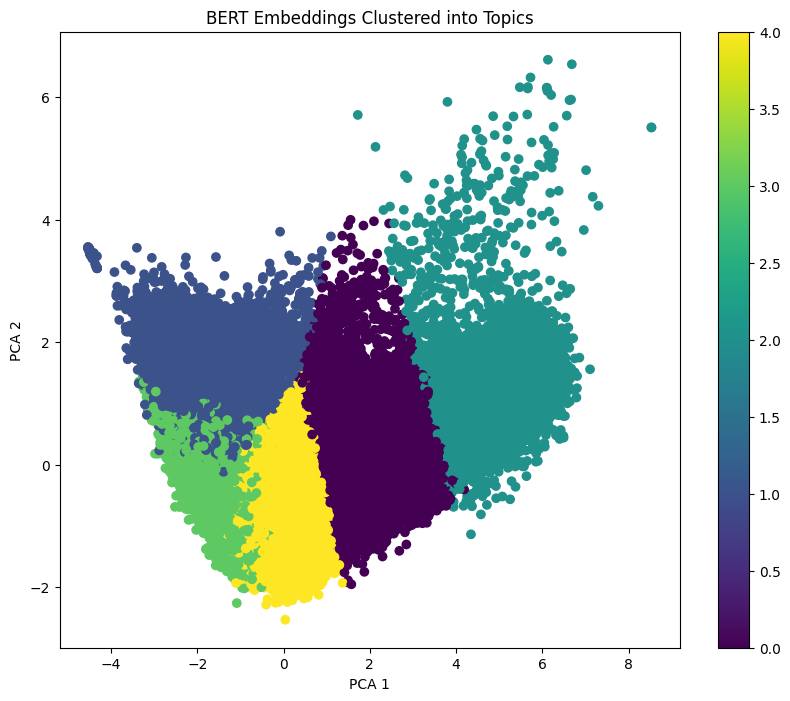


Cluster 0 examples:
['I come gay pls accept extended family would freak tf know pls accept extended family would freak tf know pls accept extended family would freak tf know thank', 'motivate get mundane necessary task do low I work since August 1st I good online hour apply everything I drive Uber bring cash several task I need get do around house I yet tackle I time world none motivation normal person I could put music I could put series sitcom I see hundred time I could turn get work do Regardless I find sit chair computer watch old sitcom I see 100 time list chore I would like get weekend 1 empty load dishwasher 2 put clean clothe away 3 clean litter box 4 Wash refill water bottle cat I normal three cat ago 5 filing lot file I would file I could find bill stack need pay 5 Frame Kids senior pic put hearth 6 Empty box last job send 7 Remove cat hair sofa ottoman 8 Update calendar new school crap I attend get wrong I love kid I want need Senior Parents Camp little much 9 clean uneaten

In [ ]:
# Extract embeddings and convert to a NumPy array with consistent shape
embeddings = np.vstack(df['bert_embeddings'].to_numpy())

# Clustering with K-means
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings)
labels = kmeans.labels_

# Add cluster labels to the original dataframe
df['Cluster'] = labels

# Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('BERT Embeddings Clustered into Topics')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# Print example texts from each cluster to interpret topics
for i in range(n_clusters):
    print(f"\nCluster {i} examples:")
    print(df[df['Cluster'] == i]['cleaned_text'].sample(5).tolist())

- Cluster 0: **Emotional Overload and Struggles with Motivation**
    - Expressions of deep personal struggles with individuals seeking support for issues like depression and overwhelming daily tasks.

- Cluster 1: **Humor, Distractions, and Casual Interactions**
  - Random statements about personal desires, mentions of crushes, social media, gaming, and challenges

- Cluster 2: **Loneliness and Deep Personal Struggles**
  - Narratives of depression, anxiety, and isolation, where individuals share their life struggles and seek advice.

- Cluster 3:  **Suicidal Thoughts and Crisis**
  - Raw expressions of despair and suicidal thoughts related to immediate personal crises.
- Cluster 4: **Life Reflection, Coping, and Existential Anxiety**
  - Descriptions of individuals feeling trapped by chronic depression or life circumstances, expressing a need for change or relief.